In [1]:
# importing libraries
import os
import zipfile
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import keras
import cv2
%matplotlib inline
#import K-Means
from sklearn.cluster import KMeans
# important metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
data = []
label = []
path = "train/train/"
c = 0
d = 0
IMG_SIZE = 32
for file in os.listdir(path):
    img=cv2.imread(path+file)
    img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    img=img.astype('float32')
    if file[:3]=='cat':
        if c==500: continue
        c+=1
        label.append("cat")
    else:
        if d==500: continue
        d+=1
        label.append("dog")
    data.append(img)
data = np.array(data)

In [3]:
data.shape

(1000, 32, 32, 3)

In [4]:
data_label = []
for i in label:
    if i=="cat": data_label.append(0)
    else: data_label.append(1)
data_label = np.array(data_label)

In [5]:
data = data/255.0
reshaped_data = data.reshape(len(data),-1)
reshaped_data.shape

(1000, 3072)

In [6]:
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(reshaped_data)
kmeans.cluster_centers_.shape

c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


(2, 3072)

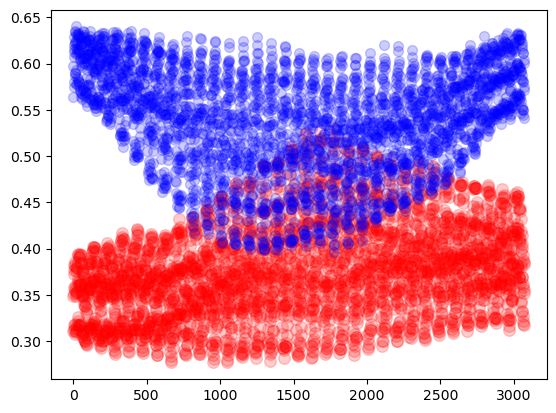

In [7]:
x_data = [i for i in range(3072)]
plt.scatter(x_data,kmeans.cluster_centers_[0], color = 'red',alpha=0.2,s=70)
plt.scatter(x_data,kmeans.cluster_centers_[1] , color = 'blue',alpha=0.2,s=50)

In [8]:
# mapping labels from cluster to original labels
def get_reference_dict(clusters,data_label):
    reference_label = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(clusters))):
        index = np.where(clusters == i,1,0)
        num = np.bincount(data_label[index==1]).argmax()
        reference_label[i] = num
    return reference_label
# Mapping predictions to original labels
def get_labels(clusters,refernce_labels):
    temp_labels = np.random.rand(len(clusters))
    for i in range(len(clusters)):
        temp_labels[i] = reference_labels[clusters[i]]
    return temp_labels

In [9]:
reference_labels = get_reference_dict(clusters,data_label)
predicted_labels = get_labels(clusters,reference_labels)
print(accuracy_score(predicted_labels,data_label))

0.511


Accuracy for k = 2:  0.511


c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Accuracy for k = 16:  0.55


c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Accuracy for k = 64:  0.602


c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Accuracy for k = 100:  0.626


c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Accuracy for k = 256:  0.689


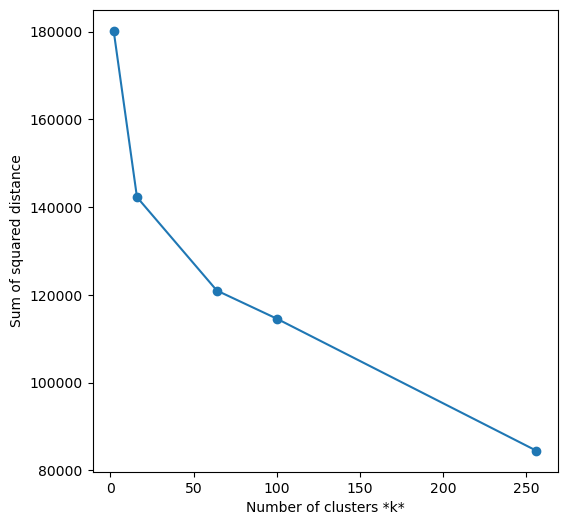

In [10]:
sse = []
list_k = [2,16,64,100,256]
for k in list_k:
    km = KMeans(n_clusters=k)
    clusters = km.fit_predict(reshaped_data)
    sse.append(km.inertia_)
    reference_labels = get_reference_dict(clusters,data_label)
    predicted_labels = get_labels(clusters,reference_labels)
    print(f"Accuracy for k = {k}: ", accuracy_score(predicted_labels,data_label))
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

### Notes
1. 256 clusters give 69% accuracy because this method involves no feature extraction
2. There are 2 clusters (cat and dog) but this method of clustering does not suit so well because some dogs might look more like cats and vice-versa

## Using transfer learning 

In [11]:
from keras.applications.resnet import preprocess_input
import keras.utils as image
import keras

In [12]:
model =   keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE,3))

In [13]:
def extract_vector(data_holder):

    resnet_feature_list = []

    for im in data_holder:

        im = image.img_to_array(im) 

        img = preprocess_input(np.expand_dims(im.copy(), axis=0))

        resnet_feature = model.predict(img)

        resnet_feature_np = np.array(resnet_feature)

        resnet_feature_list.append(resnet_feature_np.flatten())
    return np.array(resnet_feature_list)

In [14]:
array = extract_vector(data)
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(array)

1/1 [==============================] - 0s 26ms/step


c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [15]:
reference_labels = get_reference_dict(clusters,data_label)
predicted_labels = get_labels(clusters,reference_labels)

In [16]:

from sklearn.metrics import accuracy_score
print(accuracy_score(predicted_labels,data_label))

0.575


Text(0.5, 23.52222222222222, 'predicted label')

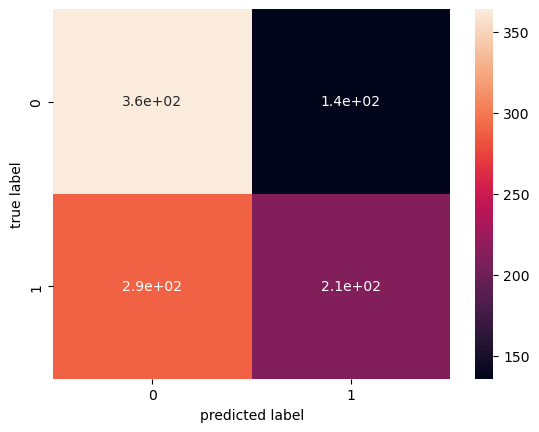

In [17]:
mat = confusion_matrix(data_label,predicted_labels )
sns.heatmap(mat, annot=True)
plt.ylabel('true label')
plt.xlabel('predicted label')